C:\Users\soham\AppData\Local\Temp\ipykernel_18404\4132318774.py:22: UserWarning: Parsing dates in %m-%d-%Y %H:%M format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(date_str, dayfirst=True)


Initial Data Shape: (40160, 14)

Cleaned Data Shape: (40160, 21)

Crime Type Distribution:
Crime Description
BURGLARY               1980
VANDALISM              1975
FRAUD                  1965
DOMESTIC VIOLENCE      1932
FIREARM OFFENSE        1931
ROBBERY                1928
KIDNAPPING             1920
IDENTITY THEFT         1918
SEXUAL ASSAULT         1917
ASSAULT                1915
TRAFFIC VIOLATION      1915
PUBLIC INTOXICATION    1912
HOMICIDE               1909
CYBERCRIME             1899
ILLEGAL POSSESSION     1895
ARSON                  1894
DRUG OFFENSE           1890
EXTORTION              1873
COUNTERFEITING         1871
VEHICLE - STOLEN       1862
SHOPLIFTING            1859
Name: count, dtype: int64

Training model...

Model Accuracy: 23.08%

Classification Report:
                     precision    recall  f1-score   support

              ARSON       0.32      0.34      0.33       372
            ASSAULT       0.32      0.30      0.31       373
           BURGLARY       

C:\Users\soham\AppData\Local\Temp\ipykernel_18404\4132318774.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_counts.values, y=crime_counts.index, palette='viridis')


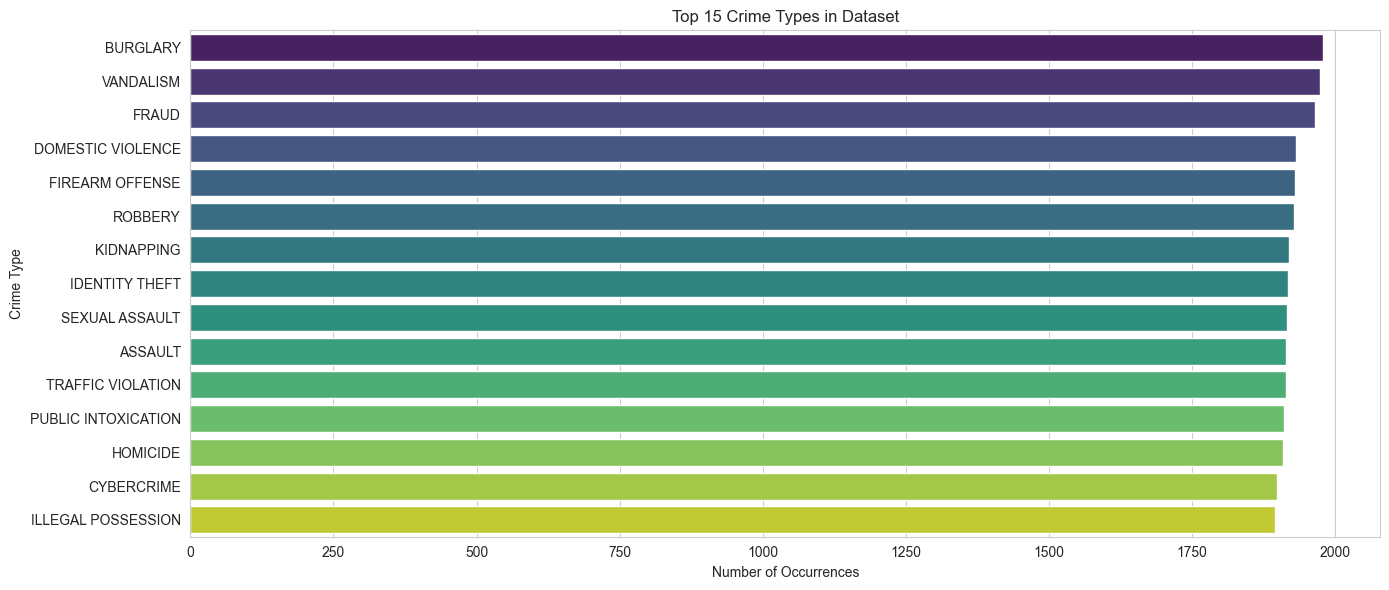

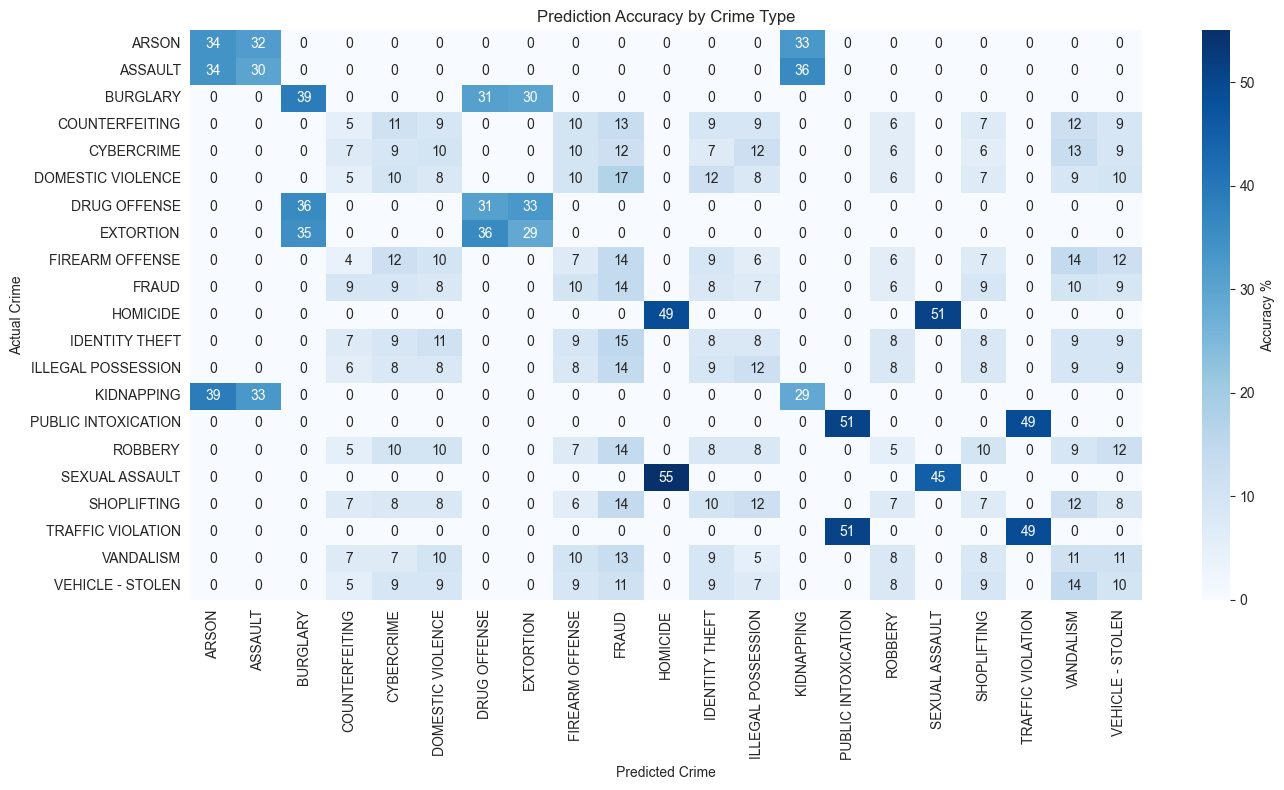

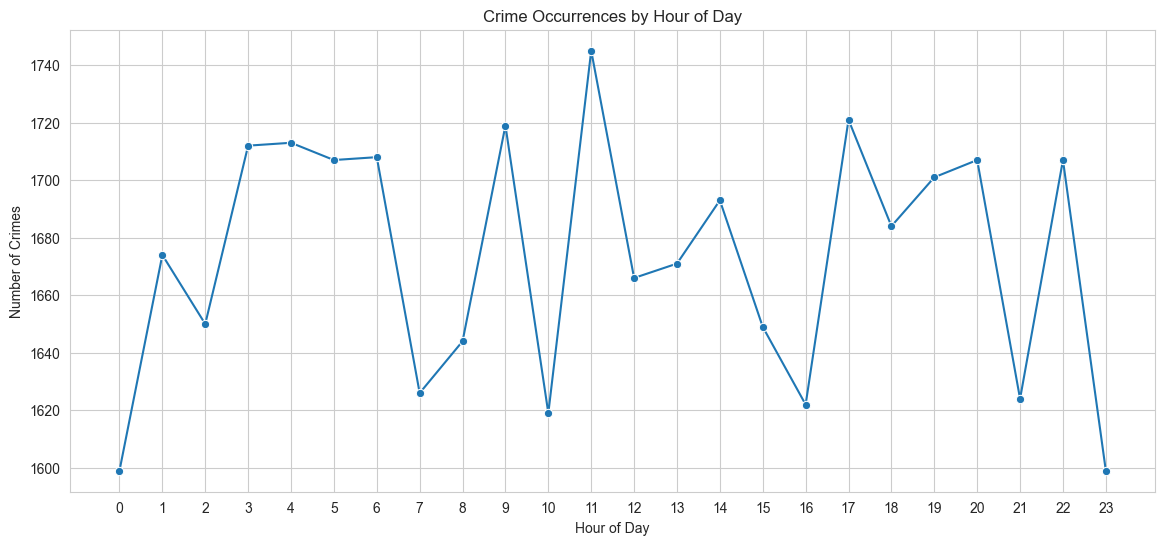


Making example prediction...

Predicted Crime: DRUG OFFENSE

Top 3 Possible Crimes:
- DRUG OFFENSE: 10.7% probability
- EXTORTION: 9.4% probability
- BURGLARY: 9.2% probability


'DRUG OFFENSE'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline


# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Custom date parser function
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=True)
    except:
        return pd.NaT

# Load the dataset with custom date parsing
crime_data = pd.read_csv('crime_dataset_india.csv')

# Convert date columns with error handling
date_cols = ['Date Reported', 'Date of Occurrence', 'Time of Occurrence', 'Date Case Closed']
for col in date_cols:
    crime_data[col] = crime_data[col].apply(parse_date)

# Data Cleaning and Feature Engineering
print("Initial Data Shape:", crime_data.shape)

# Handle missing values
crime_data['Case Closed'] = crime_data['Case Closed'].fillna('No')
crime_data['Victim Gender'] = crime_data['Victim Gender'].replace('X', 'Other')
crime_data['Weapon Used'] = crime_data['Weapon Used'].fillna('Unknown')

# Extract temporal features with error handling
crime_data['Hour'] = crime_data['Time of Occurrence'].dt.hour.fillna(-1)
crime_data['Month'] = crime_data['Date of Occurrence'].dt.month.fillna(-1)
crime_data['DayOfWeek'] = crime_data['Date of Occurrence'].dt.dayofweek.fillna(-1)
crime_data['Year'] = crime_data['Date of Occurrence'].dt.year.fillna(-1)

# Create time-based features
crime_data['Is_Night'] = crime_data['Hour'].apply(lambda x: 1 if 0 <= x < 6 or x >= 20 else 0 if x != -1 else -1)
crime_data['Is_Weekend'] = crime_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0 if x != -1 else -1)

# Create crime severity feature
crime_severity = {
    'HOMICIDE': 5, 'SEXUAL ASSAULT': 5, 'KIDNAPPING': 4,
    'ASSAULT': 4, 'EXTORTION': 3, 'BURGLARY': 3,
    'VEHICLE - STOLEN': 2, 'VANDALISM': 2, 'FRAUD': 2,
    'COUNTERFEITING': 2, 'IDENTITY THEFT': 2, 'DRUG OFFENSE': 3,
    'PUBLIC INTOXICATION': 1, 'CYBERCRIME': 2, 'ARSON': 4,
    'TRAFFIC VIOLATION': 1
}
crime_data['Crime_Severity'] = crime_data['Crime Description'].map(crime_severity).fillna(2)  # Default medium severity

# Prepare features and target
features = ['City', 'Hour', 'Month', 'DayOfWeek', 'Year', 
            'Victim Age', 'Victim Gender', 'Weapon Used',
            'Police Deployed', 'Is_Night', 'Is_Weekend', 'Crime_Severity']
target = 'Crime Description'

# Filter out rows with missing critical data
crime_data = crime_data.dropna(subset=['Crime Description', 'City'])
crime_data = crime_data[crime_data['Hour'] != -1]  # Remove rows with invalid time

print("\nCleaned Data Shape:", crime_data.shape)
print("\nCrime Type Distribution:")
print(crime_data[target].value_counts())

# Split data
X = crime_data[features]
y = crime_data[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_features = ['City', 'Victim Gender', 'Weapon Used']
numeric_features = ['Hour', 'Month', 'DayOfWeek', 'Year', 
                   'Victim Age', 'Police Deployed', 
                   'Is_Night', 'Is_Weekend', 'Crime_Severity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Handle class imbalance
smote = SMOTE(random_state=42)

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        max_depth=10,
        min_samples_split=5
    ))
])

# Train model
print("\nTraining model...")
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create prediction results dataframe
results = X_test.copy()
results['Actual Crime'] = y_test
results['Predicted Crime'] = y_pred

# Add time information
results['Time'] = results['Hour'].apply(lambda x: f"{x:02d}:00-{(x+1)%24:02d}:00")
day_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
results['Day'] = results['DayOfWeek'].map(day_map)

# Display sample predictions
print("\nSample Predictions:")
sample_preds = results.sample(10, random_state=42)[['City', 'Time', 'Day', 'Actual Crime', 'Predicted Crime']]
print(sample_preds.to_string(index=False))

# Visualizations
# 1. Crime Type Distribution
plt.figure(figsize=(14, 6))
crime_counts = crime_data['Crime Description'].value_counts().head(15)
sns.barplot(x=crime_counts.values, y=crime_counts.index, palette='viridis')
plt.title('Top 15 Crime Types in Dataset')
plt.xlabel('Number of Occurrences')
plt.ylabel('Crime Type')
plt.tight_layout()
plt.show()

# 2. Prediction Accuracy by Crime Type
plt.figure(figsize=(14, 8))
pred_crosstab = pd.crosstab(results['Actual Crime'], results['Predicted Crime'], 
                           normalize='index').round(2)*100
sns.heatmap(pred_crosstab, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Accuracy %'})
plt.title('Prediction Accuracy by Crime Type')
plt.xlabel('Predicted Crime')
plt.ylabel('Actual Crime')
plt.tight_layout()
plt.show()

# 3. Crimes by Hour of Day
plt.figure(figsize=(14, 6))
hourly_crimes = crime_data.groupby('Hour')['Crime Description'].count()
sns.lineplot(x=hourly_crimes.index, y=hourly_crimes.values, marker='o')
plt.title('Crime Occurrences by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# Prediction function for new cases
def predict_crime(city, hour, month, dayofweek, victim_age, victim_gender, weapon, police_deployed):
    """Predict crime type for given parameters"""
    input_data = pd.DataFrame({
        'City': [city],
        'Hour': [hour],
        'Month': [month],
        'DayOfWeek': [dayofweek],
        'Year': [2020],  # Using base year
        'Victim Age': [victim_age],
        'Victim Gender': [victim_gender],
        'Weapon Used': [weapon],
        'Police Deployed': [police_deployed],
        'Is_Night': [1 if hour < 6 or hour >= 20 else 0],
        'Is_Weekend': [1 if dayofweek >= 5 else 0],
        'Crime_Severity': [3]  # Default medium severity
    })
    
    prediction = pipeline.predict(input_data)[0]
    probabilities = pipeline.predict_proba(input_data)[0]
    
    # Get top 3 predictions
    crime_classes = pipeline.named_steps['classifier'].classes_
    top3_idx = np.argsort(probabilities)[-3:][::-1]
    top3_crimes = crime_classes[top3_idx]
    top3_probs = probabilities[top3_idx]
    
    print(f"\nPredicted Crime: {prediction}")
    print("\nTop 3 Possible Crimes:")
    for crime, prob in zip(top3_crimes, top3_probs):
        print(f"- {crime}: {prob:.1%} probability")
    
    return prediction

# Example prediction
print("\nMaking example prediction...")
predict_crime(
    city='Delhi',
    hour=20,
    month=7,
    dayofweek=5,  # Saturday
    victim_age=35,
    victim_gender='M',
    weapon='Knife',
    police_deployed=8
)